# <centre> Parameter Search Analysis </centre>

#### Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Define the path for the data

In [2]:
fold = 0

tasks = ['Task099_HarP', 'Task098_Dryad', 'Task097_DecathHip']
# path = '/local/scratch/aranem/Lifelong-nnUNet-storage/nnUNet_param_search/nnUNet_ext/2d/Task099_HarP_Task098_Dryad_Task097_DecathHip/nnUNetTrainerEWC__nnUNetPlansv2.1/Generic_UNet/SEQ'
path = '/local/scratch/aranem/Lifelong-nnUNet-storage/nnUNet_param_search/nnUNet_ext/2d/Task099_HarP_Task098_Dryad_Task097_DecathHip/nnUNetTrainerMiB__nnUNetPlansv2.1/Generic_ViT_UNetV2/base/not_task_specific/SPT/SEQ'

# tasks = ['Task079_UCL', 'Task078_I2CVB', 'Task077_ISBI', 'Task076_DecathProst']
# path = '/local/scratch/aranem/Lifelong-nnUNet-storage/nnUNet_param_search/nnUNet_ext/2d/Task079_UCL_Task078_I2CVB_Task077_ISBI_Task076_DecathProst/nnUNetTrainerMiB__nnUNetPlansv2.1/Generic_UNet/SEQ'
# path = '/local/scratch/aranem/Lifelong-nnUNet-storage/nnUNet_param_search/nnUNet_ext/2d/Task079_UCL_Task078_I2CVB_Task077_ISBI_Task076_DecathProst/nnUNetTrainerEWC__nnUNetPlansv2.1/Generic_ViT_UNetV2/base/not_task_specific/SPT/SEQ'

path_exp = os.path.join(path, 'experiments')
path_eval = os.path.join(path, 'evaluation')

#### Load and Transform the data

In [3]:
# -- Load the data -- #
def loadData(tasks):
    data_exp = dict()
    data_eval = dict()
    for experiment in os.listdir(path_exp):
        # Get folder name
        settings = os.listdir(os.path.join(path_exp, experiment)) # Might include folders like ewc_data that are useless
        for set in settings:
            t = list()
            data_exp[set] = dict()
            data_eval[set] = dict()
            for idx, task in enumerate(tasks):
                t.append(task)
                # Data from training
                input_path = os.path.join(path_exp, experiment, set, '_'.join(t), 'fold_'+str(fold), 'val_metrics.csv')
                if os.path.isfile(input_path):
                    data_obj = open(input_path, 'r')
                    res = pd.read_csv(data_obj, delimiter = '\t')
                    # -- Transform epoch column so it only contains the epoch number -- #
                    res['Epoch'] = res['Epoch'].apply(lambda x: int(x.split('_')[-1]) + idx*125)
                    data_exp[set][idx] = res
                else:
                    try:
                        del data_exp[set]
                    except:
                        pass

                # Data from evaluation
                input_eval = os.path.join(path_eval, experiment, set, '_'.join(t), 'fold_'+str(fold), 'summarized_val_metrics.csv')
                if os.path.isfile(input_eval):
                    data_obj = open(input_eval, 'r')
                    res = pd.read_csv(data_obj, delimiter = '\t')
                    data_eval[set][idx] = res
                else:
                    try:
                        del data_eval[set]
                    except:
                        pass

            if set in data_exp:
                data_exp[set] = pd.concat(list(data_exp[set].values()))
                data_exp[set] = data_exp[set].drop(['seg_mask', 'subject_id'], axis=1)
                data_exp[set] = data_exp[set].drop(data_exp[set][(data_exp[set].metric == 'IoU')].index).reset_index(drop=True)
                data_exp[set] = data_exp[set].groupby(['Epoch', 'Task'])['value'].mean().reset_index()
            if set in data_eval:
                data_eval[set] = pd.concat(list(data_eval[set].values()))
                data_eval[set] = data_eval[set].drop(['trainer', 'network', 'overall train order', 'used head for eval', 'trained on fold', 'seg mask', 'mean +/- std [in %]', 'checkpoint'], axis=1)
                data_eval[set] = data_eval[set].drop(data_eval[set][(data_eval[set].metric == 'IoU')].index).reset_index(drop=True)
                data_eval[set]['mean'] = data_eval[set].apply(lambda x: float(x['mean +/- std'].split(' +/- ')[0]), axis=1)
                data_eval[set]['std'] = data_eval[set].apply(lambda x: float(x['mean +/- std'].split(' +/- ')[1]), axis=1)
    return data_exp, data_eval

In [4]:
data, eval = loadData(tasks)

#### Visualize the per experiment in one plot based on results from training

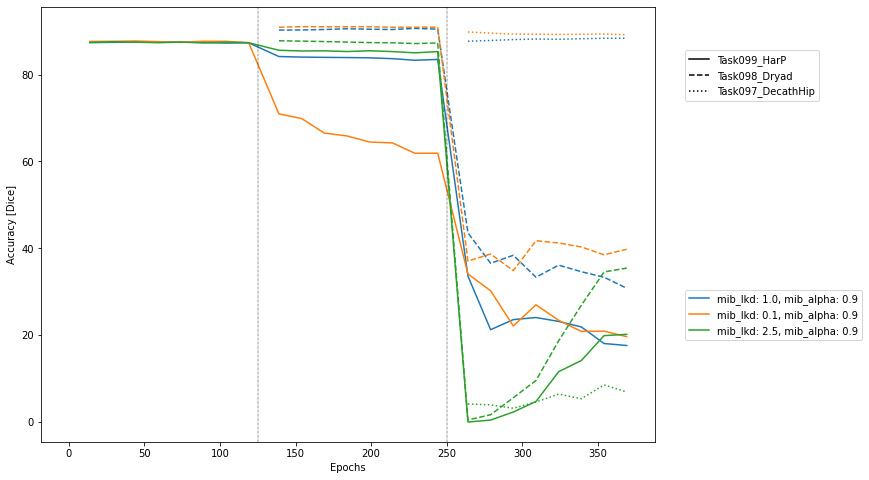

In [5]:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot()
styles = ['-', '--', ':', '-.']

# Plot the data
for exp in data.keys():
    color = None
    for task, fill in zip(tasks, styles):
        if color is not None:
            ax.plot(data[exp][(data[exp].Task == task)]['Epoch'],
                    data[exp][(data[exp].Task == task)]['value']*100,
                    ls=fill, color=color, fillstyle='none')
        else:
            ax.plot(data[exp][(data[exp].Task == task)]['Epoch'],
                    data[exp][(data[exp].Task == task)]['value']*100,
                    ls=fill, fillstyle='none')
        color = ax.get_lines()[-1].get_color()

# Add labels to legend
for t, f in zip(tasks, styles):
    ax.plot(0, 0, label=t, ls=f)
    
for x in range(1, len(tasks)):
    ax.axvline(x=125*x, color="black",ls='-.').set_linewidth(.4)
    
leg = ax.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left', borderaxespad=0.)
[lgd.set_color('black') for lgd in leg.legendHandles]

# -- Extract colors and add to legend
colors = list()
for i in ax.get_lines():
    colors.append(i.get_color())

try:
    colors.remove('black')
except:
    pass

# Plot the legend
import matplotlib.lines as mlines
handles = list()
for i, exp in enumerate(data.keys()):
    # Build the label
    label = ''
    l_list = exp.split('--')
    for l_ in l_list:
        l = l_.split('_')
        label += '_'.join(l[:-1]) + ': ' + l[-1] + ', '
    label = label[:-2]

    col = mlines.Line2D([], [], color=colors[i*len(tasks)], label=label)
    handles.append(col)
        
leg1 = ax.legend(handles=handles, bbox_to_anchor=(1.05, 0.35), loc='upper left', borderaxespad=0.)

leg = ax.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left', borderaxespad=0.)
[lgd.set_color('black') for lgd in leg.legendHandles]

ax.add_artist(leg1)

# Add labels for axis
plt.xlabel('Epochs')  
plt.ylabel('Accuracy [Dice]')

# Show plot
plt.show()

#### Visualize the per experiment in one plot based on results from evaluation

In [6]:
# Initialize DF
columns = ['experiment', 'task']

t = list()    
for task in tasks:
    t.append(task)
    columns.append(', \n'.join(t))
forgets = pd.DataFrame([], columns = columns)

# Define an empty row
row = dict()
for col in columns:
    row[col] = None

for exp in eval.keys():
    label = ''
    l_list = exp.split('--')
    for l_ in l_list:
        l = l_.split('_')
        label += '_'.join(l[:-1]) + ': ' + l[-1] + ', '
    label = label[:-2]
    row['experiment'] = label
    t = list()
    base_val = None
    row['task'] = tasks[0]
    for i, task in enumerate(tasks):
        t.append(task)
        # Calculate forgetting
        res = eval[exp].loc[(eval[exp]['trained on'] == ' -- '.join(t)) & (eval[exp]['eval on task'] == tasks[0])]['mean +/- std']
        if i > 0:
            row[', \n'.join(t)] = base_val - float(res.iloc[0].split(' +/- ')[0])*100
        else:
            base_val = float(res[0].split(' +/- ')[0])*100
            row[', \n'.join(t)] = 0
        
    # Fill the row
    row_series = pd.Series(list(row.values()), index = columns)

    # Append row to DF
    forgets = forgets.append(row_series, ignore_index=True)
forgets = forgets.fillna(0)
forgets = forgets.set_index(forgets['experiment']).drop(['experiment'], axis=1)

In [7]:
forgets

,task,Task099_HarP,"Task099_HarP, \nTask098_Dryad","Task099_HarP, \nTask098_Dryad, \nTask097_DecathHip"
experiment,,,,
"mib_lkd: 1.0, mib_alpha: 0.9",Task099_HarP,0,4.36,75.93
"mib_lkd: 0.1, mib_alpha: 0.9",Task099_HarP,0,25.39,72.11
"mib_lkd: 2.5, mib_alpha: 0.9",Task099_HarP,0,2.12,67.66


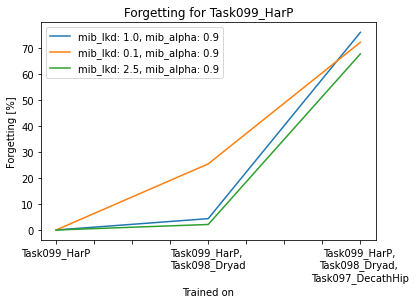

In [8]:
# Plot the data
forgets_ = forgets.drop(['task'], axis=1)
ax = forgets_.T.plot(title=f'Forgetting for {tasks[0]}', kind='line', rot=0)

# Add labels for axis
ax.set_xlabel('Trained on')  
ax.set_ylabel('Forgetting [%]')
ax.legend(title=None)

#### Determine best setting
For this we mean of the DSC from every intermediate model and select the one with the highest score. This considers indirectly the amount of Forgetting and Remembering, ie. Positive Backward Transfer.

In [9]:
res = dict()
best_mean = 0
best_std = np.inf
for exp in eval.keys():
    res[exp] = [np.mean(eval[exp]['mean']), np.mean(eval[exp]['std'])]
    if res[exp][0] > best_mean:
        best_std = res[exp][1]
        best_set = exp
        best_mean = res[exp][0]
    elif res[exp][0] == best_mean and res[exp][1] < best_std:
        best_std = res[exp][1]
        best_set = exp
        best_mean = res[exp][0]


Best setting: mib_lkd_0.1--mib_alpha_0.9


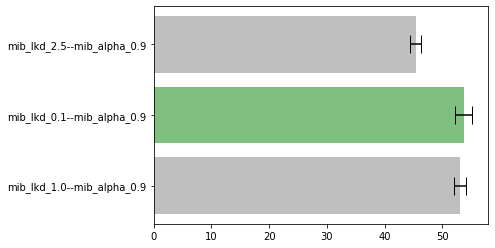

In [10]:
# Plot
exps = list(res.keys())
means = [x[0]*100 for _, x in res.items()]
y_pos = np.arange(len(means))
stds = [x[1]*100 for _, x in res.items()]

# Build the plot
fig, ax = plt.subplots()
clrs = ['grey' if (x < max(means)) else 'green' for x in means]
ax.barh(y_pos, means, xerr=stds, align='center', alpha=0.5, ecolor='black', capsize=9, color=clrs)
ax.set_yticks(y_pos)
ax.set_yticklabels(exps)

print("Best setting: {}".format(best_set))